# Introduction: Sam, Alex and Donald

This is a test to see if one can play around with the BTX kinetics, given in Chapter 1, and see if any insights into the behaviour of the system can be obtained just by interacting with the profiles.

## Python imports

In [1]:
import scipy as sp
from scipy.integrate import odeint
import scipy.linalg
import scipy.optimize

import matplotlib.pyplot as plt

from ipywidgets import interact

%matplotlib inline
plt.style.use("ggplot")

## System specification

Define reactions for the Benzene-Toluene-Xylene (BTX) system:

$$ \begin{align}
\mathrm{B} + 0.5\mathrm{E}	&\rightarrow	\mathrm{T} \\
\mathrm{T} + 0.5\mathrm{E}	&\rightarrow	\mathrm{X} \\
2\mathrm{B}	&\rightarrow	\mathrm{D}+\mathrm{H}
\end{align}
$$

with $k_1 = 1.0$, $k_2 = 1.0$ and $k_3 = 10.0$

In [2]:
def btx_rate(C,t):
    #rate constants
    k1 = 1.0
    k2 = 1.0
    k3 = 10.0
    
    cB = C[0]
    cE = C[1]
    cT = C[2]
    
    r1 = k1*cB*cE**0.5
    r2 = k2*cT*cE**0.5
    r3 = k3*cB**2
    
    #species rate equations
    rB = -r1 - 2*r3
    rE = -0.5*r1 - 0.5*r2
    rT = r1 - r2
    rX = r2
    rD = r3
    rH = r3
    
    dC = sp.array([rB,rE,rT,rX,rD,rH])
    return dC

## Standard concentration profile

Quick check to see if a standard batch concentration profile can be generated.

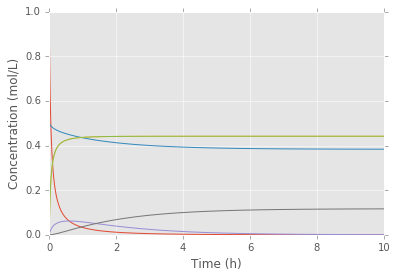

In [3]:
t_end = 10
N_pts = 100

ts = sp.logspace(-3,sp.log10(t_end),N_pts)
Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])

cs = odeint(btx_rate,Cf,ts)

plt.figure()
plt.hold(True)

plt.plot(ts, cs[:,0])
plt.plot(ts, cs[:,1])
plt.plot(ts, cs[:,2])
plt.plot(ts, cs[:,3])
plt.plot(ts, cs[:,4])
plt.plot(ts, cs[:,5])

plt.xlabel('Time (h)')
plt.ylabel('Concentration (mol/L)')
plt.show()

## Part 1: Optimisation of a single batch

Having only knowledge of the batch, Sam tries to optimise the reaction by locating an optimal reaction time.

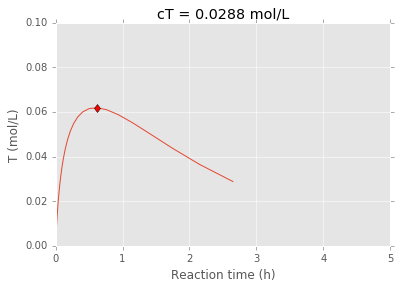

In [4]:
def plot_fn1(t_end=1.5):
    N_pts = 50;
    ts = sp.logspace(-4,sp.log10(t_end),N_pts)
    Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])

    cs = odeint(btx_rate,Cf,ts)

    plt.figure()
    plt.hold(True)

    #plt.plot(cs[:,0], cs[:,2])
    plt.plot(ts, cs[:,2])
    k = sp.where(cs[:,2] == max(cs[:,2]))
    plt.plot(ts[k],cs[k,2], 'rd')

    plt.xlabel('Reaction time (h)')
    plt.ylabel('T (mol/L)')
    plt.axis([0,5,0,0.1])
    plt.title('cT = %.4f mol/L'%(cs[-1,2]))
    
    plt.show()
    
#Generate interactive plot
interact(plot_fn1, t_end=(0.01,5,0.001))

## Result 1
Optimal reaction time seems to occur near $\mathrm{t} = 0.59\,\mathrm{h}$, giving a maximum Toluene concentration of $0.0619\,\mathrm{mol/L}$

## Part 2: Mixing concentration gives better result
Adam accidentally forgets to empty all the contents of the reactor and creates a new starting concentration in the process. This new concentration does better than what Sam could achieve with the previous optimised result.

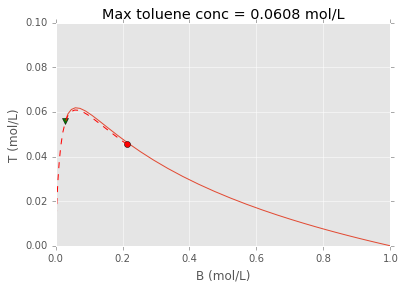

In [5]:
def plot_fn2(t_end=1.5, mix_frac=0.5):
    
    ts0 = sp.logspace(-4,sp.log10(t_end),50)
    cs0 = odeint(btx_rate,Cf,ts0)
    
    c_mix = Cf + mix_frac*(cs0[-1,:] - Cf)
    ts1 = sp.logspace(-4,sp.log10(10),50)
    cs1 = odeint(btx_rate, c_mix, ts1)
    
    plt.figure()
    plt.hold(True)
    
    plt.plot(cs0[:,0],cs0[:,2])
    plt.plot(cs0[-1,0],cs0[-1,2], 'gv')
    plt.plot(c_mix[0],c_mix[2], 'ro')
    plt.plot(cs1[:,0],cs1[:,2], 'r--')
    
    plt.xlabel('B (mol/L)')
    plt.ylabel('T (mol/L)')
    plt.axis([0,1,0,0.1])
    plt.title('Max toluene conc = %.4f mol/L'%(max(cs1[:,2])))
    
    plt.show()
    
#Generate interactive plot
interact(plot_fn2, t_end=(0.001,5,0.001), mix_frac=(0,1,0.01))

## Result 2
From the results, it appears that:
- A reaction time of $\mathrm{t} = 3\,\mathrm{h}$ and $\lambda = 0.5$ gives worse performance.
- A reaction time of $\mathrm{t} = 0.55\,\mathrm{h}$ and $\lambda = 0.5$ gives better performance.

## Part 3: Fed-batch

Donald realises that Sam and Adam are constraining themselves to the operation of standard batches only. But there are also fed-batch reactors which have not been considered that could also drive further improvement. Using this insight, he embarks on an investigation to see if he can improve the toluene concentration over the previous two attempts, using specifically a fed-batch reactor with a constant feeding profile.

The equation for a fed-batch reactor with constant density is:

$$
\frac{\mathrm{d}\mathbf{C}}{\mathrm{d}\mathrm{t}}=\mathbf{r}\left(\mathbf{C}\right)+\frac{\mathrm{F}}{\mathrm{V}\left(\mathrm{t}\right)}\left[\mathbf{C}^{0}-\mathbf{C}\right]
$$

where $\mathrm{F}$ and $\mathrm{V}$ are the fed-batch feeding rate and reactor volume in L/s and L, respectively. 

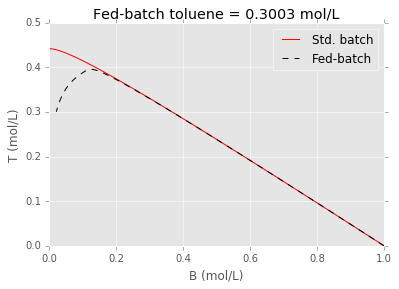

In [6]:
def dsr_fn(Cs,t,opts):
    F = opts[0]
    C0 = opts[1]
    
    #unpack the species concentrations and V
    C = Cs[:-1]
    V = Cs[-1]    #batch volume
    alpha = F/V
    
    dC = btx_rate(C,t) + alpha*(C0 - C)
    
    #append dV/dt and return
    dC = sp.hstack([dC,F])
    return dC

def plot_fn3(F=0.5, t_batch=5):
    
    #Initial conditions
    Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])
    C0 = Cf
    
    V0 = 0.1
    Cf0 = sp.hstack([Cf, V0])
    
    #integrate fed-batch
    dsr_opts = (F, C0)

    dsr_ts = sp.logspace(-4,sp.log10(t_batch),50)
    dsr_cs = odeint(dsr_fn, Cf0, dsr_ts, args=(dsr_opts,))
    
    #integrate PFR from terminating point of fed-batch?
    #batch_ts = sp.logspace(-4,sp.log10(10),50)
    #batch_cs = odeint(btx_rate,dsr_cs[-1,0:-1],batch_ts)

    #plot
    plt.figure()
    plt.hold(True)
    
    h_batch, = plt.plot(cs[:,0],cs[:,5], 'r-')
    h_fedbatch, = plt.plot(dsr_cs[:,0],dsr_cs[:,5], 'k--')
    #plt.plot(batch_cs[:,0],batch_cs[:,2], 'b')

    plt.legend([h_batch,h_fedbatch], ['Std. batch', 'Fed-batch'])
    plt.xlabel('B (mol/L)')
    plt.ylabel('T (mol/L)')
    plt.axis([0,1,0,0.5])
    #plt.title('Fed-batch toluene = %.4f mol/L'%(max(dsr_cs[:,5])))
    plt.title('Fed-batch toluene = %.4f mol/L'%(dsr_cs[-1,5]))
    
    plt.show()
    
#Generate interactive plot
interact(plot_fn3, F=(0,1,0.0001), t_batch=(0,100,0.01))

## Result 3
For a feeding rate of $\mathrm{F} = 0.1\,\mathrm{L/s}$, we can optimise the fed-batch reaction time. We find that an optimal reaction time of approximately $\mathrm{t} = 2.0\,\mathrm{h}$ corresponds to a toluene concentration of approximately $0.0733\,\mathrm{mol/L}$, which is the maximum concentration for this feeding policy.

## Additional insights
Sam, Adam and Donald think that they are close to reaching a point where no further improvements can be made. But they still don't know where the limit actaully ends. One day, Donald, forgets to switch off the reactor just after a reaction has occured. He turns off the fed-batch feeding but forgets to turn of the reactor -- the reactor continues to run with a feeding rate of zero. To Sam, Adam and Donald's surprise, they get an even better improvement to their previous best. 

With this, they realise that they have actaully created a batch sequence incorporating an initial fed-batch period, followed by a period of standard batch reaction. They realise that they could have also attached a batch after the fed-batch and optimise for this situation as well. Things are quickly becoming complicated!

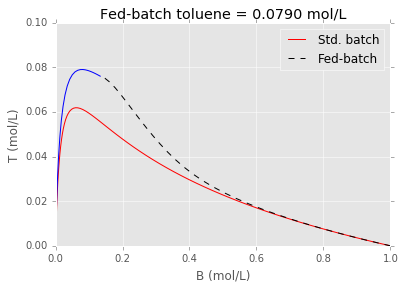

In [7]:
def plot_fn4(F=0.1, t_fedbatch=2.0, t_batch=5):
    
    #Initial conditions
    Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])
    C0 = Cf
    
    V0 = 0.1
    Cf0 = sp.hstack([Cf, V0])
    
    #integrate fed-batch
    dsr_opts = (F, C0)

    dsr_ts = sp.logspace(-4,sp.log10(t_fedbatch),50)
    dsr_cs = odeint(dsr_fn, Cf0, dsr_ts, args=(dsr_opts,))
    
    #integrate PFR from terminating point of fed-batch?
    batch_ts = sp.logspace(-4,sp.log10(t_batch),50)
    batch_cs = odeint(btx_rate,dsr_cs[-1,0:-1],batch_ts)

    #plot
    plt.figure()
    plt.hold(True)
    
    h_batch, = plt.plot(cs[:,0],cs[:,2], 'r-')
    h_fedbatch, = plt.plot(dsr_cs[:,0],dsr_cs[:,2], 'k--')
    plt.plot(batch_cs[:,0],batch_cs[:,2], 'b')

    plt.legend([h_batch,h_fedbatch], ['Std. batch', 'Fed-batch'])
    plt.xlabel('B (mol/L)')
    plt.ylabel('T (mol/L)')
    plt.axis([0,1,0,0.1])
    plt.title('Fed-batch toluene = %.4f mol/L'%(max(batch_cs[:,2])))
    
    plt.show()
    
#Generate interactive plot
interact(plot_fn4, F=(0,1,0.0001), t_fedbatch=(0,10,0.01), t_batch=(0,10,0.01))

They could also mix with feed to get an intermediate concentration that, although it is not the best, is better than what they typically get with just a standard batch reaction.

Also, what if we used a differernt reaction? Would we get the same results? Is there a way to know when we could so these things and when we can't do these?

## Conclusion
What if we told you that we could still be better. In fact, what if we told you that the best you could ever do was $0.0805\,\mathrm{mol/L}$. We are certainly close, but we are aware of this now that we know what the maximum is. How would you know how to get there? 

Furthermore, what if we told you that you actaully needed a feeding profile that was a constant F/V up to a certain point, followed by a standrad batch up to a reaction time of [] s. In this book, we will show you how we can find this out. We will also show the method for how to get to that point.

## Minimizing H2 production

## Batch reactor

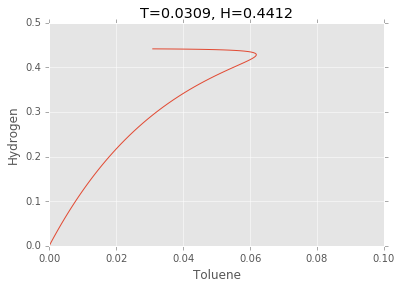

<function __main__.plot_fn5>

In [8]:
def plot_fn5(t_end):
    plt.figure()
    
    ts = sp.logspace(-3,sp.log10(t_end),100)
    cs = odeint(btx_rate,Cf,ts)
    plt.plot(cs[:,2],cs[:,5])
    
    plt.xlabel('Toluene')
    plt.ylabel('Hydrogen')
    
    plt.axis([0,0.1,0,0.5])
    plt.title("T=%.4f, H=%.4f"%(cs[-1,2],cs[-1,5]))
    plt.show()
    
interact(plot_fn5, t_end=(0.01,5,0.01))

## Fed-batch

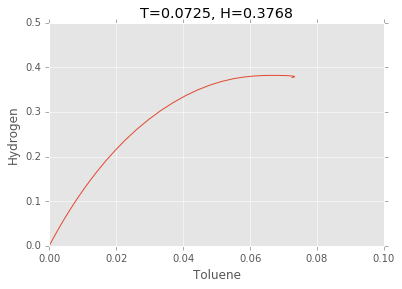

<function __main__.plot_fn6>

In [9]:
def plot_fn6(t_fedbatch=2.5, F=0.1):
    
    #Initial conditions
    Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])
    C0 = Cf
    
    V0 = 0.1
    Cf0 = sp.hstack([Cf, V0])
    
    #integrate fed-batch
    dsr_opts = (F, C0)

    dsr_ts = sp.logspace(-4,sp.log10(t_fedbatch),50)
    dsr_cs = odeint(dsr_fn, Cf0, dsr_ts, args=(dsr_opts,))
    
    plt.figure()
    
    plt.plot(dsr_cs[:,2],dsr_cs[:,5])
    
    plt.xlabel('Toluene')
    plt.ylabel('Hydrogen')
    
    plt.axis([0,0.1,0,0.5])
    plt.title("T=%.4f, H=%.4f"%(dsr_cs[-1,2],dsr_cs[-1,5]))
    plt.show()
    
interact(plot_fn6, t_fedbatch=(1e-4,5,0.01), F=(0,1.0,0.01))

## Batch followed by fed-batch

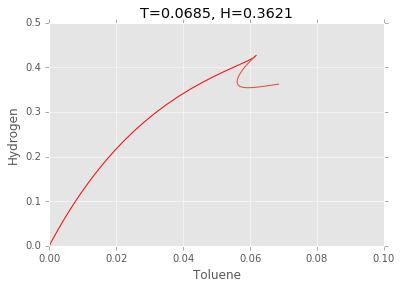

<function __main__.plot_fn7>

In [10]:
def plot_fn7(t_batch=0.55,t_fedbatch=0.7,F=0.2):
    
    #Initial conditions
    Cf = sp.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])
    C0 = Cf
    
    V0 = 0.1
    
    #integrate batch
    batch_ts = sp.logspace(-4,sp.log10(t_batch),50)
    batch_cs = odeint(btx_rate, Cf, batch_ts)
    
    #integrate fed-batch
    dsr_opts = (F, C0)
    Cf0 = sp.hstack([batch_cs[-1,:].T, V0])

    dsr_ts = sp.logspace(-4,sp.log10(t_fedbatch),50)
    dsr_cs = odeint(dsr_fn, Cf0, dsr_ts, args=(dsr_opts,))
    
    plt.figure()
    plt.hold(True)
    
    plt.plot(batch_cs[:,2],batch_cs[:,5],'r-')
    plt.plot(dsr_cs[:,2],dsr_cs[:,5])
    
    plt.xlabel('Toluene')
    plt.ylabel('Hydrogen')
    
    plt.axis([0,0.1,0,0.5])
    plt.title("T=%.4f, H=%.4f"%(dsr_cs[-1,2],dsr_cs[-1,5]))
    plt.show()
    
interact(plot_fn7, t_batch=(1e-4,5,0.01), t_fedbatch=(1e-4,5,0.01), F=(0,1.0,0.01))

## Batch with 10% fresh feed mixed at the end

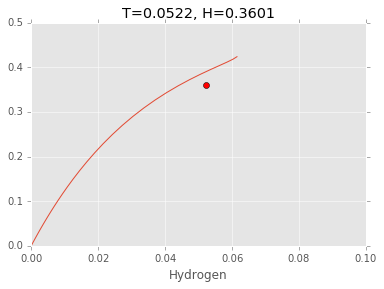

<function __main__.plot_fn8>

In [11]:
def plot_fn8(t_end=0.5, L=0.15):
    #integrate batch
    ts = sp.logspace(-4,sp.log10(t_end),50)
    cs = odeint(btx_rate, Cf, ts)
    
    #calculate mixture concentration
    c_mix = L*Cf.T + (1-L)*cs[-1,:]
    
    plt.figure()
    plt.hold(True)
    
    plt.plot(cs[:,2],cs[:,5])
    plt.plot(c_mix[2],c_mix[5], 'ro')
    
    plt.xlabel("Toluene")
    plt.xlabel("Hydrogen")
    
    plt.title("T=%.4f, H=%.4f"%(c_mix[2],c_mix[5]))
    plt.axis([0,0.1,0,0.5])
    plt.show()

interact(plot_fn8, t_end=(1e-4,5,0.01), L=(0,1,0.01))